In [72]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

In [2]:
class QPP:
    def __init__(self, *args):
        self.total_data_qubits = len(args)
        self.total_qubits = self.total_data_qubits+1
        
        self.phase_qubit = AncillaRegister(1, name="ancilla")
        self.circuit = QuantumCircuit(self.phase_qubit, *args)
        
        self.circuit_measurement = QuantumCircuit(self.total_qubits, self.total_data_qubits)
        self.circuit_measurement.measure(range(1, self.total_qubits), range(self.total_data_qubits))
        
    def add_input(self, bit_string):
        assert len(bit_string) == self.total_data_qubits, "Different amount of registers" 
        
        bit_string = self.parse_bit_string(bit_string)
    
        for qubit, bit in enumerate(bit_string):
            if(bit == '1'):
                self.circuit.x(qubit+1)
        self.add_barrier()
        
    def parse_bit_string(self, bit_string):
        return bit_string[::-1]
        
    def add_barrier(self):
        self.circuit.barrier()
    
    def prepare(self, bit_string, show_oracle=False, show_state_vector=False):
        self.add_oracle(bit_string, show_oracle)
        if(show_state_vector):
            self.show_state_vector()
        self.add_measurement()
            
    def add_oracle(self, bit_string, show_oracle):
        assert len(bit_string) <= self.total_data_qubits, "Different amount of registers" 
        
        bit_string = self.parse_bit_string(bit_string)
        qubits_iterator = range(self.total_qubits)
        
        oracle = QuantumCircuit(self.total_qubits, name="Oracle")
        
        oracle.x(0)
        oracle.h(qubits_iterator)
        
        for qubit, bit in enumerate(bit_string): 
            if(bit == '0'):
                oracle.cx(qubit+1, 0)
                
        oracle.h(qubits_iterator)
        
        if(show_oracle): 
            display(oracle.draw('mpl'))
        
        self.circuit.append(oracle, qubits_iterator)
        
    def show_state_vector(self):
        display(Statevector(self.circuit).draw('latex'))
        
    def add_measurement(self):
        self.circuit.compose(self.circuit_measurement, inplace=True)
    
    def measure(self, backend=Aer.get_backend("aer_simulator"), shots=1000):
        transpiled_circuit = transpile(self.circuit, backend)
        results = backend.run(transpiled_circuit, shots=shots).result().get_counts()
        display(plot_histogram(results))
        return {'results':results, 'shots':shots}
    
    def show(self):
        display(self.circuit.draw("mpl"))
        

In [3]:
all_documents = QuantumRegister(1, name="documents")
false_info = QuantumRegister(1, name="falsification")
wanted = QuantumRegister(1, name="wanted")
bribe = QuantumRegister(1, name="bribe")

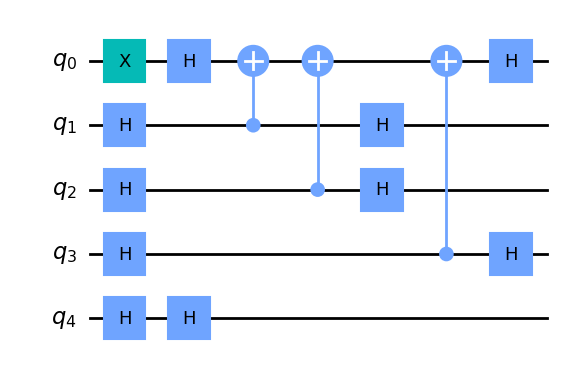

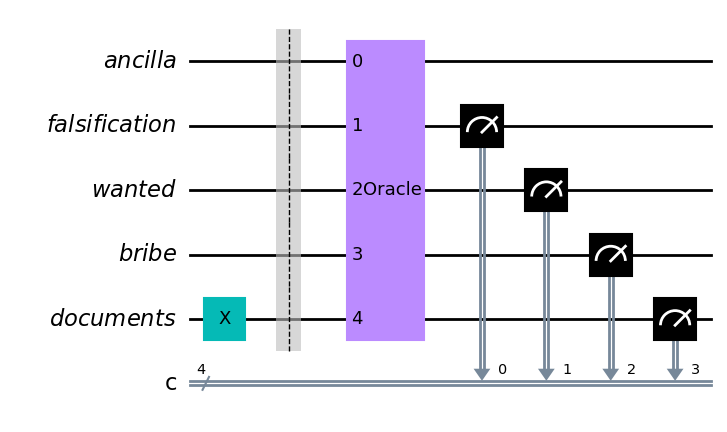

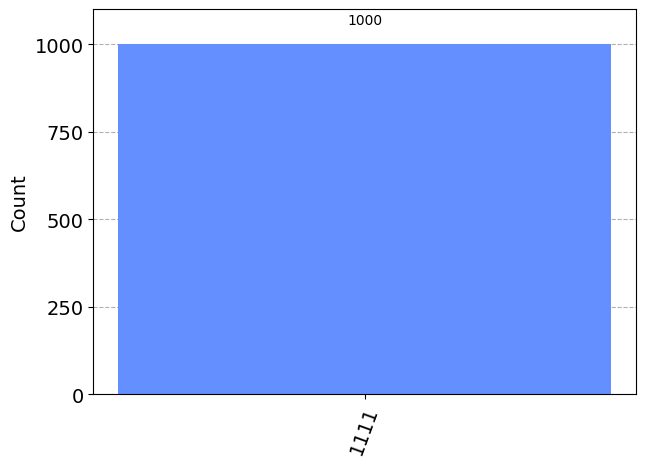

In [18]:
data = [false_info, wanted, bribe, all_documents]
algorithm = QPP(*data)
algorithm.add_input("1000")
algorithm.prepare(bit_string="1000", show_oracle=True)
algorithm.show()
measurement_result = algorithm.measure()

In [19]:
total_shots = measurement_result['shots']
result = measurement_result['results']

In [20]:
def show_results(shots, result):
    get_percentage = lambda total, x: (x/total)*100
    ordered_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    
    if(not '0' in list(ordered_result.keys())[0]):
        print('Recieved the correct result!!!')
    else:
        print('The result is Incorrect!!!')        
    
    print('-'*50)
    
    print("string - total - percentage")
    for bit_string, total in list(ordered_result.items()):
        print(f'{bit_string}     {total}    {int(get_percentage(shots, total))}%')

In [21]:
show_results(total_shots, result)

Recieved the correct result!!!
--------------------------------------------------
string - total - percentage
1111     1000    100%


In [5]:
from qiskit_ibm_provider import IBMProvider
import os
from dotenv import load_dotenv
load_dotenv()

IBMProvider.save_account(token=os.getenv('IBM_API_TOKEN'), overwrite=True)

In [6]:
provider = IBMProvider()
backend = provider.get_backend('ibmq_lima')

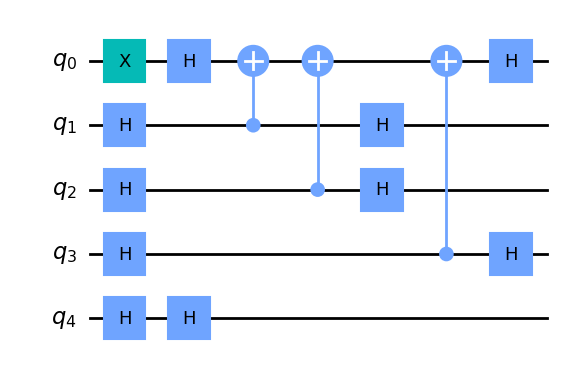

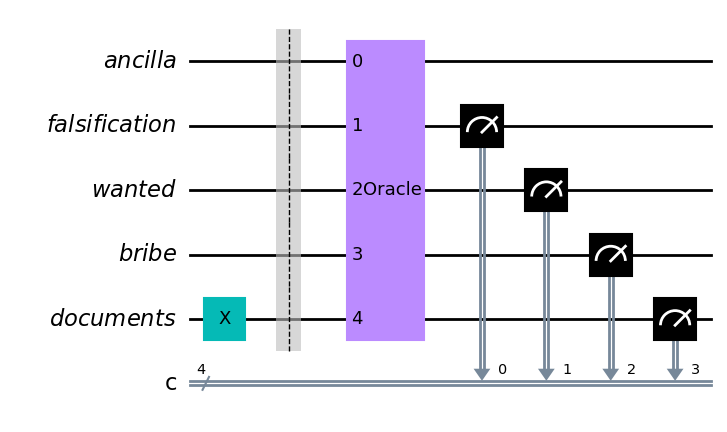

In [ ]:
data = [false_info, wanted, bribe, all_documents]
algorithm = QPP(*data)
algorithm.add_input("1000")
algorithm.prepare(bit_string="1000", show_oracle=True)
algorithm.show()
measurement_result = algorithm.measure(backend=backend)

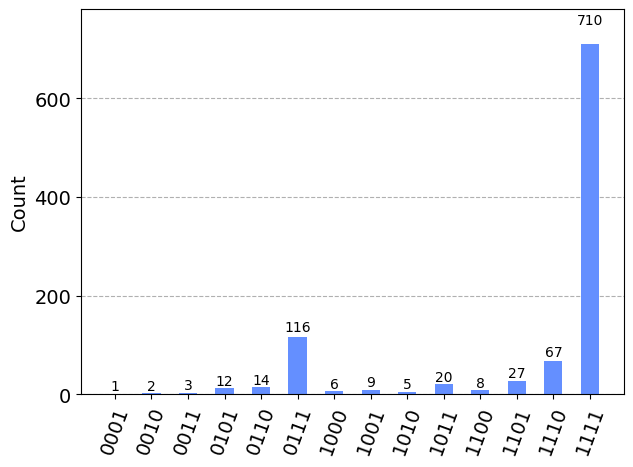

Recieved the correct result!!!
--------------------------------------------------
string - total - percentage
1111     710    71%
0111     116    11%
1110     67    6%
1101     27    2%
1011     20    2%
0110     14    1%
0101     12    1%
1001     9    0%
1100     8    0%
1000     6    0%
1010     5    0%
0011     3    0%
0010     2    0%
0001     1    0%


In [22]:
job_id = ''
job = provider.backend.retrieve_job(job_id)
result = job.result().get_counts()
display(plot_histogram(result))
show_results(1000, result)

---

In [23]:
all_documents = QuantumRegister(1, name="documents")
false_info = QuantumRegister(1, name="falsification")
wanted = QuantumRegister(1, name="wanted")
bribe = QuantumRegister(1, name="bribe")

# Documents

- 70% of the time is false and 30% true

In [76]:
def get_theta(B):
    return np.arcsin(B) * 2

In [79]:
#a = cos(theta/2)
#B = e^(i phi) sin(theta/2)

B = 1/np.sqrt(3)
theta = get_theta(B)
a = np.cos(theta/2)
print(f'theta: {theta}')
print(f'a --> {a}')
print(f'B --> {B}')
print(f'a+B prob --> {a**2+B**2}')

theta: 1.230959417340775
a --> 0.8164965809277259
B --> 0.5773502691896258
a+B prob --> 1.0


In [57]:
def show_stats(shots, result):
    get_percentage = lambda total, x: (x/total)*100
    ordered_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    
    print("string - total - percentage")
    for bit_string, total in list(ordered_result.items()):
        print(f'{bit_string}     {total}    {int(get_percentage(shots, total))}%')

In [90]:
def test_probabilities(circuit):
    display(circuit.draw('mpl'))
    display(Statevector(circuit).draw('latex'))
    display(plot_bloch_multivector(circuit))

    circuit.measure_all()

    display(circuit.draw('mpl'))
    measurement_result = Aer.get_backend('aer_simulator').run(circuit, shots=1000).result().get_counts()
    display(show_stats(1000, measurement_result))

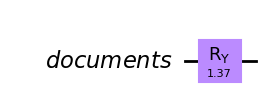

<IPython.core.display.Latex object>

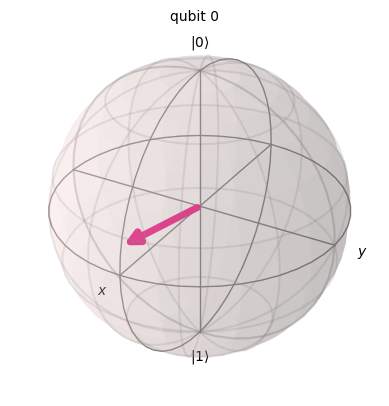

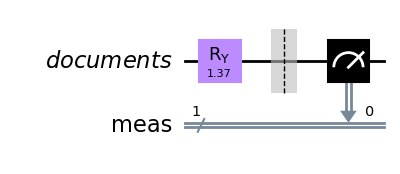

string - total - percentage
0     611    61%
1     389    38%


None

In [91]:
documents_prob_test = QuantumCircuit(all_documents)
documents_prob_test.ry(theta, all_documents)
test_probabilities(documents_prob_test)

# False info

- 60% false and 40% true

In [87]:
#a = cos(theta/2)
#B = e^(i phi) sin(theta/2)

#B^2 = 0.4
#B = sqrt(0.4) --> sqrt(40)/sqrt(100) --> sqrt(40)/10

B = np.sqrt(40)/10
theta = get_theta(B)
a = np.cos(theta/2)
print(f'theta: {theta}')
print(f'a --> {a}')
print(f'B --> {B}')
print(f'a+B prob --> {a**2+B**2}')

theta: 1.369438406004566
a --> 0.7745966692414834
B --> 0.6324555320336759
a+B prob --> 1.0


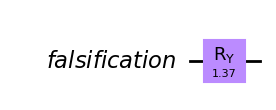

<IPython.core.display.Latex object>

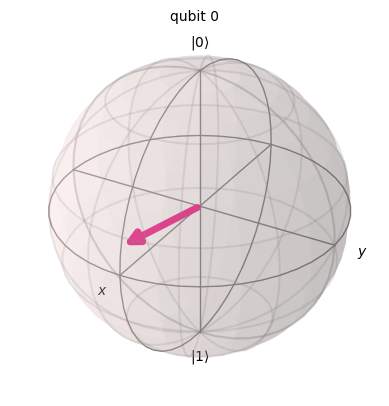

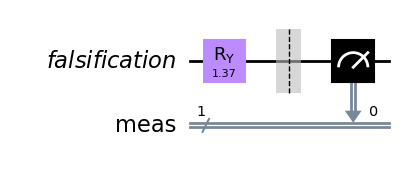

string - total - percentage
0     601    60%
1     399    39%


None

In [92]:
false_info_prob_test = QuantumCircuit(false_info)

false_info_prob_test.ry(theta, false_info)

test_probabilities(false_info_prob_test)